In [37]:
import os

import pandas as pd
import numpy as np
import duckdb
from duckdb.typing import DOUBLE, INTEGER, VARCHAR
from datetime import datetime, timedelta

In [38]:
TAXI_DUCKDB_PATH = "../nyc_traffic_2016.duckdb"

con = duckdb.connect(TAXI_DUCKDB_PATH, read_only=False)

In [39]:
con.query("""SELECT
    AVG(
        EXTRACT(EPOCH FROM (
            CAST(dropoff_datetime AS TIMESTAMP) 
            - 
            CAST(pickup_datetime AS TIMESTAMP)
            ))
        ) AS average_trip_duration_seconds
        FROM
          taxi_data;""")

┌───────────────────────────────┐
│ average_trip_duration_seconds │
│            double             │
├───────────────────────────────┤
│             969.5513397498753 │
└───────────────────────────────┘

So the average time period is about 15 minutes.

## Slice By Hour of the Day

In [13]:
def generate_time_of_day_slices(con, start_time, end_time, start_dt_column_name, end_dt_column_name, table_name, slice_minutes=15):
    """
    Generates slices of the total taxi trip dataset, each of which represent the trips whose durations overlap a given 15 minute window
    of time of day.
    For example, if the window is 8:30 AM to 8:45 AM, a trip which started at 8:30 but has an end time of 8:35 would be included.

    Args:
        con (_duckdb.DuckDBPyConnection): the connection to the duckDB database
        start_time (str): The overall start time of the data range.
        end_time (str): The overall end time of the data range.
        dt_column_name (str): The name of the datetime column in the table.
        table_name (str): The name of the table to query.
        slice_minutes (int): The size of the time slice in minutes.
    
    Yields:
        df: a dataframe containing all of the trips between two times of day
    """
    start_dt = datetime.strptime(start_time, "%H:%M")
    end_dt = datetime.strptime(end_time, "%H:%M")

    current_time = start_dt
    
    # Ensure the loop runs until the current time slice is fully processed
    while current_time < end_dt:
        slice_end_time = current_time + timedelta(minutes=slice_minutes)
        
        # Determine the effective end time for the slice, ensuring it doesn't 
        # exceed the overall end_dt
        effective_end_time = min(slice_end_time, end_dt)
        
        # 1. Format datetimes as strings for SQL (ISO 8601 is generally safe)
        start_str = current_time.strftime('%H:%M:%S')
        end_str = effective_end_time.strftime('%H:%M:%S')

        # 2. Construct the SQL query
        # Use >= start and < end to ensure non-overlapping, contiguous slices
        sql_query = f"""
            SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
            FROM {table_name}
            WHERE CAST({start_dt_column_name} as TIME) >= '{start_str}'
              AND CAST({end_dt_column_name} as TIME) < '{end_str}';
        """
        df = con.query(sql_query).df()

        yield (start_str, end_str, df)
        
        # Move to the next slice
        current_time = effective_end_time

## Get Manhattan Node Graph

In [3]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

# download the Manhattan road network
place = "Manhattan, New York City, USA"
G = ox.graph_from_place(place, network_type="drive")

# project the graph
G_proj = ox.project_graph(G)

# gt the geodataframe of nodes
nodes_gdf = ox.graph_to_gdfs(G_proj, edges=False)
target_crs = G_proj.graph['crs']

/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/set_operations.py:451: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/set_operations.py:451: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


### Create Manhattan Boundary and Select Trips within

In [41]:
nyc_boundary = gpd.read_file("geo/nyc_boroughs.json")
manhattan_bound = nyc_boundary[nyc_boundary['BoroName'] == "Manhattan"].union_all()
manhattan_gdf = gpd.GeoDataFrame(geometry=[manhattan_bound], crs="EPSG:4326")

In [8]:
def get_points_within_mask(boundary_gdf, points):
    """
    Returns a mask of equal length to the input array of points, with True indicating that the point is within the polygon
    described by boundary and False indicating that it is not.

    boundary (gpd.GeoDataFrame): boundary describing which points you want to keep
    points (GeoDataFrame): GeoDataFrame containing the points to filter

    Returns:
    pd.Series: a mask of equal length to the input array describing which points are within the geometry
    """

    if points.crs != boundary_gdf.crs:
        boundary_gdf = boundary_gdf.to_crs(points.crs) # reproject points to boundary

    merged = gpd.sjoin(
        left_df=points,
        right_df=boundary_gdf,
        how='left',
        predicate='within' 
    )

    mask = merged['index_right'].notna()

    return mask


def get_trips_within(boundary, trips):
    """
    Returns an updated GeoDataFrame with trips filtered for whether or not both their start and end points are within the
    geography provided by boundary.

    boundary (gpd.GeoDataFrame): boundary describing which points you want to keep
    trips (gpd.GeoDataFrame): GeoDataFrame containing trips, namely with the pickup_longitude, pickup_latitude, 
    dropoff_longitude, dropoff_latitude columns

    Returns:
    pd.DataFrame: a dataframe containing a subset of the inputted trips, which have their start and end points both within the geometry
    """

    pickup_points = gpd.GeoDataFrame(
        trips.copy(),
        geometry=gpd.points_from_xy(
            x=trips['pickup_longitude'], 
            y=trips['pickup_latitude']
        ),
        crs="EPSG:4326"
    )
    
    dropoff_points = gpd.GeoDataFrame(
        trips.copy(),
        geometry=gpd.points_from_xy(
            x=trips['dropoff_longitude'], 
            y=trips['dropoff_latitude']
        ),
        crs="EPSG:4326"
    )
    
    # use the dummy point dfs to generate masks
    pickup_mask = get_points_within_mask(boundary, pickup_points)
    dropoff_mask = get_points_within_mask(boundary, dropoff_points)
    
    combined_mask = pickup_mask & dropoff_mask
    
    trips_within = trips.loc[combined_mask].copy()
    
    return trips_within

In [9]:
def assign_points_to_nodes(graph, points):
    """
    Assigns the points in the provided GeoDataFrame to each of the nodes, returning an array of nodes per point, which can later be appended
    to the points dataframe.
    graph (networkx.classes.multidigraph.MultiDiGraph): osmnx generated graph containing node representations of street intersections
    points (gpd.GeoDataFrame): a series of points

    Returns:
    pd.Series: series containing the node corresponding to each of the points passed in
    """

    target_crs = graph.graph['crs']

    if points.crs != target_crs:
        points_proj = points.to_crs(target_crs)
    else:
        points_proj = points

    projected_x = points_proj.geometry.x.tolist()
    projected_y = points_proj.geometry.y.tolist()
    
    nearest_node_ids = ox.nearest_nodes(
        graph,
        X=projected_x, 
        Y=projected_y
    )

    return pd.Series(nearest_node_ids, index=points.index)

## Collect Unique Node Combos in the Network

In [26]:
slice_gen = generate_time_of_day_slices(con, "08:00", "09:00", 'pickup_datetime', 'dropoff_datetime', 'taxi_data')

In [ ]:
node_pairs_list = []
node_pair_counts = {}

for start, end, slice in slice_gen:
    within = get_trips_within(manhattan_gdf, slice)

    pickup_gdf = gpd.GeoDataFrame(
        within,
        geometry=gpd.points_from_xy(
            x=within['pickup_longitude'], 
            y=within['pickup_latitude']
        ),
        crs="EPSG:4326"
    )

    dropoff_gdf = gpd.GeoDataFrame(
        within,
        geometry=gpd.points_from_xy(
            x=within['dropoff_longitude'], 
            y=within['dropoff_latitude']
        ),
        crs="EPSG:4326"
    )

    pickup_nodes = assign_points_to_nodes(G_proj, pickup_gdf)
    dropoff_nodes = assign_points_to_nodes(G_proj, dropoff_gdf)

    within['pickup_node'] = pickup_nodes
    within['dropoff_node'] = dropoff_nodes

    node_pairs = within[['pickup_node', 'dropoff_node']]
    unique_routes = node_pairs.drop_duplicates()
    
    node_pairs_list.append(unique_routes)
    node_pair_counts[start + "-" + end] = node_pairs.value_counts()

In [28]:
unique_node_pairs = pd.concat(node_pairs_list)
unique_node_pairs = unique_node_pairs.drop_duplicates()

In [29]:
unique_node_pairs.shape

(693776, 2)

There are around 630 thousand routes which we need to route.

In [22]:
node_pair_counts

{'08:15:0008:30:00': pickup_node  dropoff_node
 42422026     42433712        117
 42439440     42429876        104
 42422026     42433715         91
 42435422     42429876         88
 42446849     42436060         85
                             ... 
 42435680     42450341          1
              42450290          1
              42450057          1
              42450055          1
              42452117          1
 Name: count, Length: 460460, dtype: int64,
 '08:30:0008:45:00': pickup_node  dropoff_node
 42435422     42445867        103
 42439440     42429876         91
 4443775465   42430597         85
 42439840     42435598         81
 42434268     5849918502       70
                             ... 
 13324038870  42443807          1
              42445001          1
              42437058          1
              42437914          1
              42438506          1
 Name: count, Length: 457539, dtype: int64,
 '08:45:0009:00:00': pickup_node  dropoff_node
 42446849     42436060 

## Calculate the Routes and Identify the Number of Times Each Node Appears per Time Slice

In [31]:
G_proj = ox.add_edge_speeds(G_proj)
G_proj = ox.add_edge_travel_times(G_proj)

In [ ]:
import networkx as nx
import collections
from tqdm import tqdm

def aggregate_node_visitations(G_proj, route_frequencies, weight_metric="travel_time"):
    """
    Finds the shortest path for each unique O-D pair and aggregates the total 
    visitation count for every node in the graph, including duplicates.
    """
    
    node_visitation_counts = collections.defaultdict(int)

    total_count = 0
    total_missed = 0
    # iterate through the unique routes and their frequencies
    for (u, v), trip_count in tqdm(route_frequencies.items(), total=route_frequencies.shape[0]):
        total_count += trip_count
        try:
            # find the shortest path (list of node IDs) between the O-D pair
            route_nodes = nx.shortest_path(
                G_proj,
                source=u,
                target=v,
                weight=weight_metric
            )

            # for each node in the route, add the number of times the trip appears to the final node_visitation count
            for node_id in route_nodes:
                node_visitation_counts[node_id] += trip_count
                
        except nx.NetworkXNoPath:
            # Handle cases where no route can be found
            # print(f"Warning: No path found between node {u} and {v}. Skipping.")
            total_missed += trip_count
    
    print(f"Missed: {total_missed / total_count * 100}%")
    count_series = pd.Series(node_visitation_counts, name="count")
    
    return count_series

In [81]:
nodes_projected = nodes_gdf.to_crs("EPSG:4326")
nodes_projected['x'] = nodes_projected.geometry.x
nodes_projected['y'] = nodes_projected.geometry.y
nodes_coords = nodes_projected[['x', 'y']]

In [83]:
for time_period, pair_counts in node_pair_counts.items():
    node_counts = aggregate_node_visitations(G_proj, pair_counts, weight_metric="travel_time")
    node_counts_df = node_counts.to_frame()

    node_count_w_coords_df = node_counts_df.join(nodes_coords, how='left')
    node_count_w_coords_df.head()

    node_counts.to_csv(f"out/node_counts_{time_period}.csv", header=True)

    with open(f"out/node_events_{time_period}.txt", "w+") as out:
        for i, row in node_count_w_coords_df.iterrows():
            out.writelines([f"{row['x']} {row['y']}\n"] * int(row['count']))

100%|██████████| 455158/455158 [31:08<00:00, 243.63it/s] 

Missed: 0.08968018887483506%


AttributeError: 'collections.defaultdict' object has no attribute 'to_frame'

# Intermediate Visualization

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
import numpy as np

slice_names = ["08_00_00-08_15_00", "08_15_00-08_30_00", "08_30_00-08_45_00", "08_45_00-09_00_00"]

#for slice in 

In [7]:
slice = "08_00_00-08_15_00"
node_count_series = pd.read_csv(f"out/node_counts_{slice}.csv", index_col=0, names=['node_id', 'count'], header=0)

In [10]:
node_data = nodes_gdf.join(node_count_series, how='left')
node_data['count'] = node_data['count'].fillna(0).astype(int)

In [11]:
node_data

,y,x,highway,street_count,ref,geometry,count
osmid,,,,,,,
42421728,4.516859e+06,587729.043733,traffic_signals,3,NaN,POINT (587729.044 4516859.09),5449
42435337,4.516784e+06,587688.489793,traffic_signals,3,NaN,POINT (587688.49 4516784.068),5519
42421731,4.516925e+06,587607.544456,traffic_signals,4,NaN,POINT (587607.544 4516924.975),635
42432736,4.516935e+06,587770.034444,traffic_signals,3,NaN,POINT (587770.034 4516934.917),5215
42437916,4.516849e+06,587566.635485,NaN,4,NaN,POINT (587566.635 4516849.227),309
...,...,...,...,...,...,...,...
11942111842,4.511096e+06,586610.004725,motorway_junction,3,NaN,POINT (586610.005 4511095.647),3
12989986304,4.512555e+06,585674.552140,NaN,1,NaN,POINT (585674.552 4512554.717),256
12998931038,4.520989e+06,588893.375287,NaN,4,NaN,POINT (588893.375 4520988.858),1096


In [56]:
counts = node_data['count']
positive_counts = counts[counts > 0]

norm_color = plt.Normalize(positive_counts.min(), positive_counts.max())
norm_size = plt.Normalize(positive_counts.min(), positive_counts.max())

cmap_name = 'YlOrRd' 
cmap = cm.get_cmap(cmap_name)

mapped_rgba = cmap(norm_color(counts))
mapped_hex_colors = [mc.to_hex(color) for color in mapped_rgba]

node_colors = np.where(
    counts > 0,
    mapped_hex_colors,
    '#CCCCCC'
)

bgcolor = '#EEEEEE' 

min_size = 1
max_size = 15
node_sizes = np.where(
    counts > 0,
    min_size + norm_size(counts) * (max_size - min_size),
    min_size
)

/var/folders/bb/g7vlcgfn14ld8_w41331g0dw0000gn/T/ipykernel_80632/679449391.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


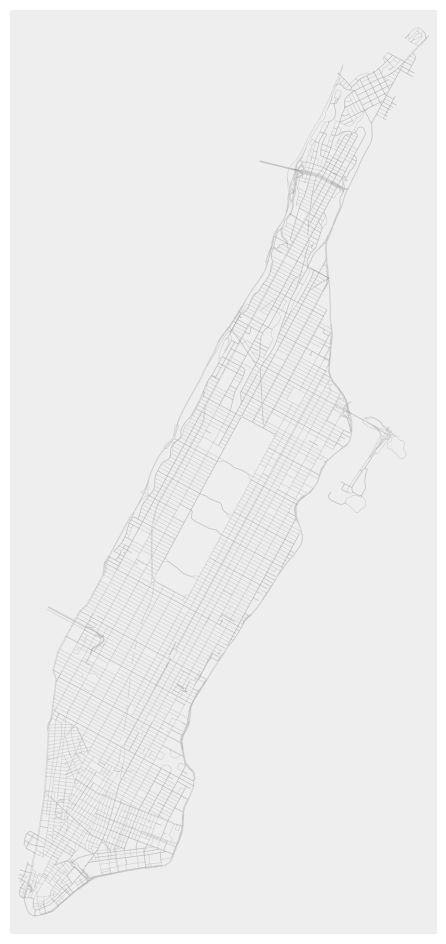

In [57]:
fig, ax = ox.plot_graph(
    G_proj,
    ax=None,
    figsize=(12, 12),
    bgcolor=bgcolor,
    edge_color='#999999',
    edge_linewidth=0.5,
    edge_alpha=0.3,
    #node_color=node_colors,
    #node_size=5,
    node_size=0,
    show=False,
    close=False,
    save=False
)

In [58]:
ax.scatter(
    node_data['x'],
    node_data['y'],
    s=node_sizes,
    c=node_colors,
    alpha=0.8,
    linewidth=0.5,
    edgecolor='k',
    zorder=5
)

sm = cm.ScalarMappable(norm=norm_color, cmap=cmap)
sm.set_array([])

cb = fig.colorbar(
    sm,
    ax=ax,
    orientation='vertical',
    shrink=0.5,
    pad=0.01
)

cb.set_label('Node Visitation Count (Log Scale)', fontsize=12)
ax.set_title('Manhattan Node Visitation Frequency', fontsize=16)

fig.savefig("maps/manhattan_node_frequency.png", dpi=300)
fig.show()

/var/folders/bb/g7vlcgfn14ld8_w41331g0dw0000gn/T/ipykernel_80632/484494815.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


# Does Not Work

In [2]:
from pynkdv.PyNKDV import *

setPath(['/Applications/QGIS.app/Contents/MacOS/../Resources/python', '/Users/tpeng/Library/Application Support/QGIS/QGIS3/profiles/default/python', '/Users/tpeng/Library/Application Support/QGIS/QGIS3/profiles/default/python/plugins', '/Applications/QGIS.app/Contents/MacOS/../Resources/python/plugins', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/matplotlib-3.3.0-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/geopandas-0.8.1-py3.9.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/pandas-1.3.3-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/opencv_contrib_python-4.3.0.36-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/numba-0.50.1-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/Fiona-1.8.13.post1-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/cftime-1.2.1-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/netCDF4-1.5.4-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/rasterio-1.1.5-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/lib-dynload', '/Applications/QGIS.app/Contents/MacOS/lib/python39.zip', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/patsy-0.5.1-py3.9.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/pyproj-3.2.0-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/scipy-1.5.1-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/statsmodels-0.11.1-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/Rtree-0.9.7-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/Pillow-7.2.0-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/numpy-1.20.1-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9/site-packages/GDAL-3.3.2-py3.9-macosx-10.13.0-x86_64.egg', '/Applications/QGIS.app/Contents/MacOS/lib/python3.9', '/Users/tpeng/Library/Application Support/QGIS/QGIS3/profiles/default/python'])

node_data = map_road_network(f"out/node_events_08_00_00-08_15_00.txt")
model = PyNKDV(node_data, bandwidth=1000, lixel_size=5, num_threads=8)
results = model.compute()
output(results, f"test_nkde.shp")

40.8778412 40.70155179999998 -73.9076185 -74.0180549
start downloading map


/Users/tpeng/miniconda3_x86/envs/pynkdv/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/tpeng/miniconda3_x86/envs/pynkdv/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/tpeng/miniconda3_x86/envs/pynkdv/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/tpeng/miniconda3_x86/envs/pynkdv/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/tpeng/minicon

AttributeError: 'LineString' object has no attribute 'reverse'

In [ ]:
import os
os.path.exists("/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/nkdv/nkdv_mac.so")

True

In [ ]:
from pynkdv.PyNKDV import *

for key in node_pair_counts.keys():
    node_data = map_road_network(f"out/node_events_{key}.txt")
    model = PyNKDV(node_data, bandwidth=1000, lixel_size=5, num_threads=8)
    results = model.compute()
    output(results, f"{key}_nkde.shp")

## Implement NetKDE or PyNKDV

## Run NetKDE over Road Network